I have used the following methods.

* I tried to implementation of distributed deep learning strategy,
* I used a pretrained ViT model [1],
* Used <b>tf.data</b> for input pipeline,
* 3 KFold cross validation,

## Prediction Pipeline
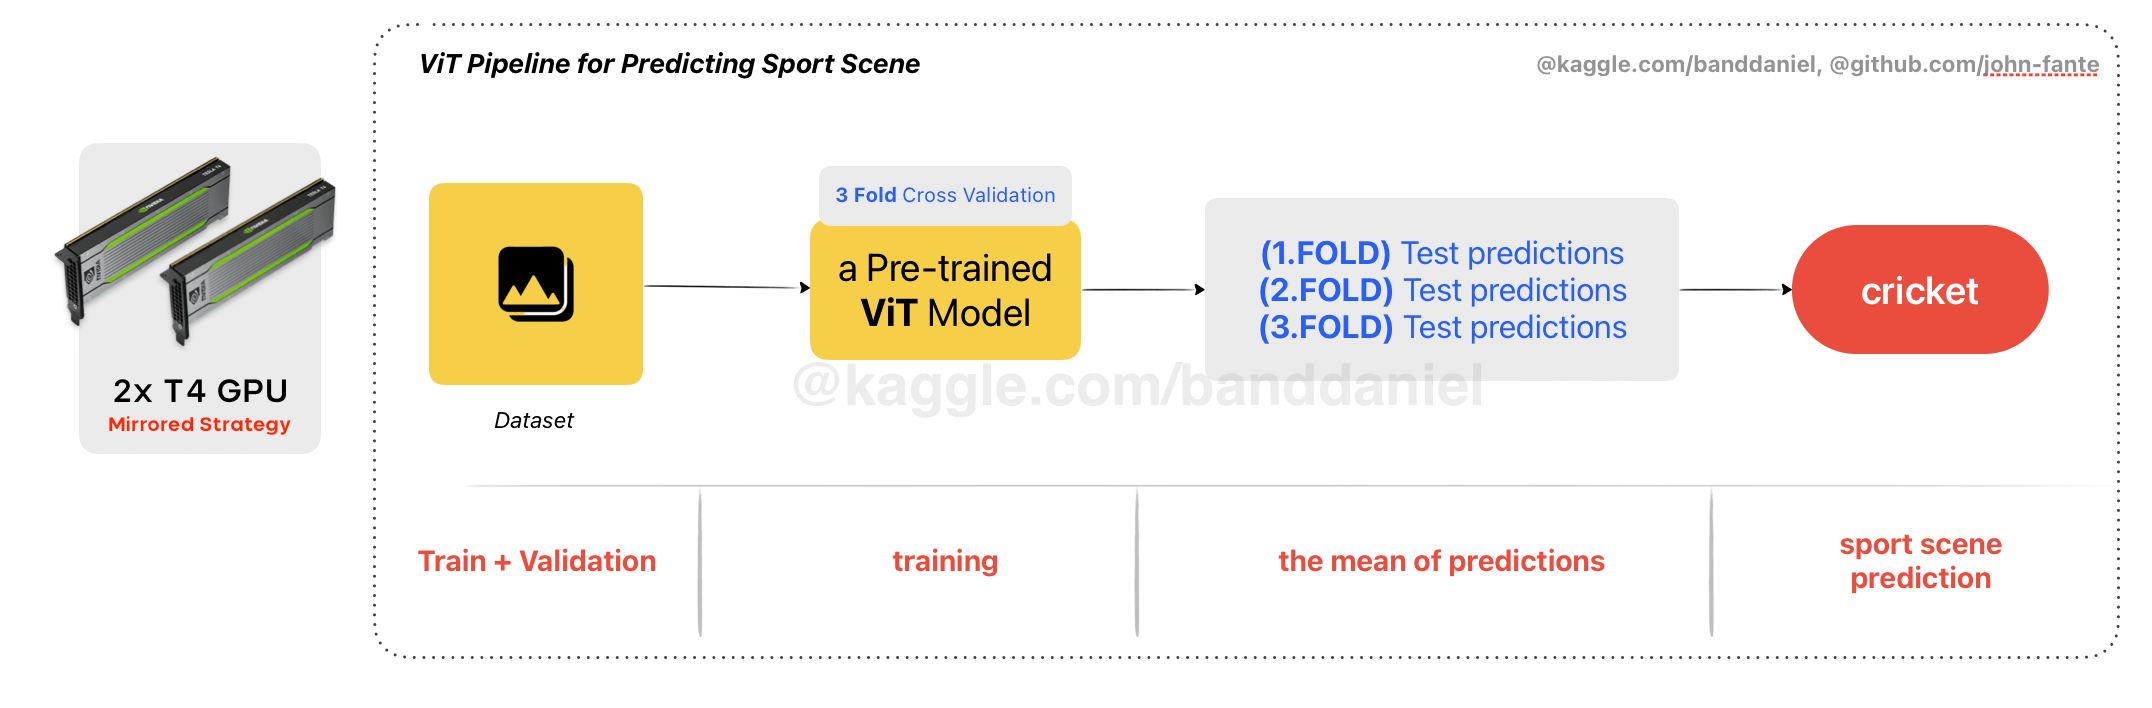

## Predictions
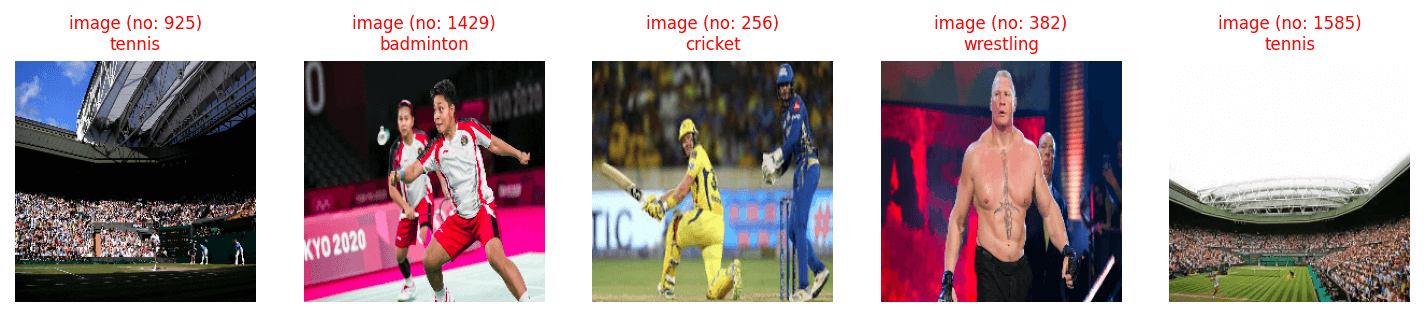
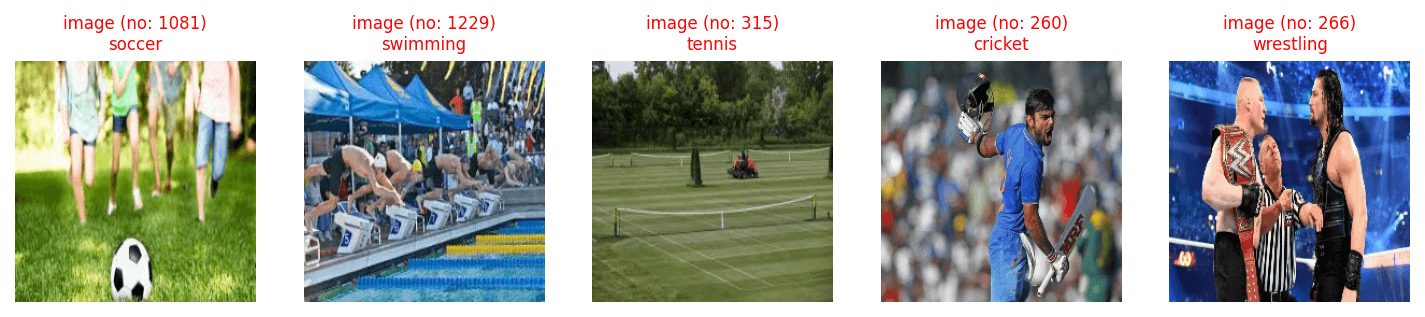

## My Another Projects
* [Diamond Detect w/Hybrid Model (ViT,CatBoost,SHAP)](https://www.kaggle.com/code/banddaniel/diamond-detect-w-hybrid-model-vit-catboost-shap)
* [Sign Detection w/Keras YOLO V8](https://www.kaggle.com/code/banddaniel/sign-detection-w-keras-yolo-v8)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)


## References
1. https://github.com/faustomorales/vit-keras

In [1]:
from IPython.display import clear_output
!pip install vit_keras
clear_output()

In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from vit_keras import vit

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model

from sklearn.model_selection import KFold

IMG_SIZE = 224, 224
BATCH_SIZE = 32
SEED = 443
AUTO = tf.data.AUTOTUNE

In [3]:
# Creatin mirrored strategy and the model

stg = tf.distribute.MirroredStrategy()

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [4]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


def create_full_img_class_df(full_path):
    data = pd.DataFrame()
    img_rows = []
    label_rows = []
    full_path_list = create_images_list(full_path)
    
    for i in range(len(full_path_list)):
        x = create_images_list(full_path_list[i])
        img_rows.extend(x)
        label_rows.extend([i]*len(x))
    
    data['img'] = img_rows
    data['label'] = label_rows
    
    return data

# look-up table
sport_classes = {0: 'badminton', 1: 'cricket', 2: 'karate', 3: 'soccer', 4: 'swimming', 5: 'tennis', 6: 'wrestling'}


train_images = create_full_img_class_df('/kaggle/input/sports-type-classification/mnt/data/dataset/bekhzod/im_class/sports/dataset/kaggle/train')
valid_images = create_full_img_class_df('/kaggle/input/sports-type-classification/mnt/data/dataset/bekhzod/im_class/sports/dataset/kaggle/valid')

# full images for cross validation
full_images = pd.concat([train_images, valid_images], axis = 0, ignore_index = True)

# label 999 means NULL label
test_images_paths = create_images_list('/kaggle/input/sports-type-classification/mnt/data/dataset/bekhzod/im_class/sports/dataset/kaggle/test/no class')
test_images = pd.DataFrame({'img': test_images_paths, 'label': 999})


print("full images (train + valid) -> ", full_images.shape[0])
print("test images -> ", test_images.shape[0])

full images (train + valid) ->  8227
test images ->  2056


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [5]:
# Reading -> Resizing -> Normalization
def img_preprocessing(img, label):
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

# Data augmentation 
def augmentation(img, label):
    img = tf.image.random_flip_left_right(img, seed = SEED)
    img = tf.image.random_flip_up_down(img, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_saturation(img, 2, 6, seed = SEED)
    
    return img, label

In [6]:
# Creating test dataset loader and tf.dataset
test_loader = tf.data.Dataset.from_tensor_slices((test_images['img'], test_images['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> ViT </span> Model

In [7]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', pretrained = True,
                            include_top = False, pretrained_top = False, classes = 7)
    
    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(256, activation = 'gelu')(X)
    X = Dense(64, activation = 'gelu')(X)
    out = Dense(7, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.00001,weight_decay = 0.0005),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 3, name = "top_3_acc", dtype=None)] )

347502902/347502902 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                            

# <span style="color:#e74c3c;"> 3 KFold </span> Training

In [8]:
fold_hists = []
test_preds = []

FOLDS = 3
EPOCHS = 5

kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
for i,(train_index, val_index) in enumerate(kf.split(full_images['img'], full_images['label'])):
    print('-'*90)
    print(str(i+1) + '.fold training')
    
    X_train_fold = full_images['img'][train_index]
    y_train_fold = full_images['label'][train_index]

    X_val_fold = full_images['img'][val_index]
    y_val_fold = full_images['label'][val_index]
    
    # tf.data datasets
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls = AUTO)
                     .map(augmentation, num_parallel_calls = AUTO)
                     .shuffle(BATCH_SIZE*10)
                     .batch(BATCH_SIZE)
                     .prefetch(AUTO))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls = AUTO)
                          .map(augmentation, num_parallel_calls = AUTO)
                          .batch(BATCH_SIZE)
                          .prefetch(AUTO))
    
    # training
    hist = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = validation_dataset)
    fold_hists.append(hist)
    
    # test predictions
    test_take1 = test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    pred = np.argmax(pred, axis = 1)
    test_preds.append(pred)

------------------------------------------------------------------------------------------
1.fold training
Epoch 1/5
172/172 [==============================] - 247s 924ms/step - loss: 1.6526 - acc: 0.4353 - top_3_acc: 0.7474 - val_loss: 1.4482 - val_acc: 0.4739 - val_top_3_acc: 0.8345
Epoch 2/5
172/172 [==============================] - 157s 910ms/step - loss: 1.2763 - acc: 0.5629 - top_3_acc: 0.8372 - val_loss: 0.9017 - val_acc: 0.7262 - val_top_3_acc: 0.9315
Epoch 3/5
172/172 [==============================] - 157s 912ms/step - loss: 0.8165 - acc: 0.7307 - top_3_acc: 0.9303 - val_loss: 0.5856 - val_acc: 0.8341 - val_top_3_acc: 0.9668
Epoch 4/5
172/172 [==============================] - 157s 910ms/step - loss: 0.5360 - acc: 0.8288 - top_3_acc: 0.9686 - val_loss: 0.4156 - val_acc: 0.8764 - val_top_3_acc: 0.9785
Epoch 5/5
65/65 [==============================] - 21s 233ms/step
------------------------------------------------------------------------------------------
2.fold training
Epoc

# <span style="color:#e74c3c;"> Training </span> Results

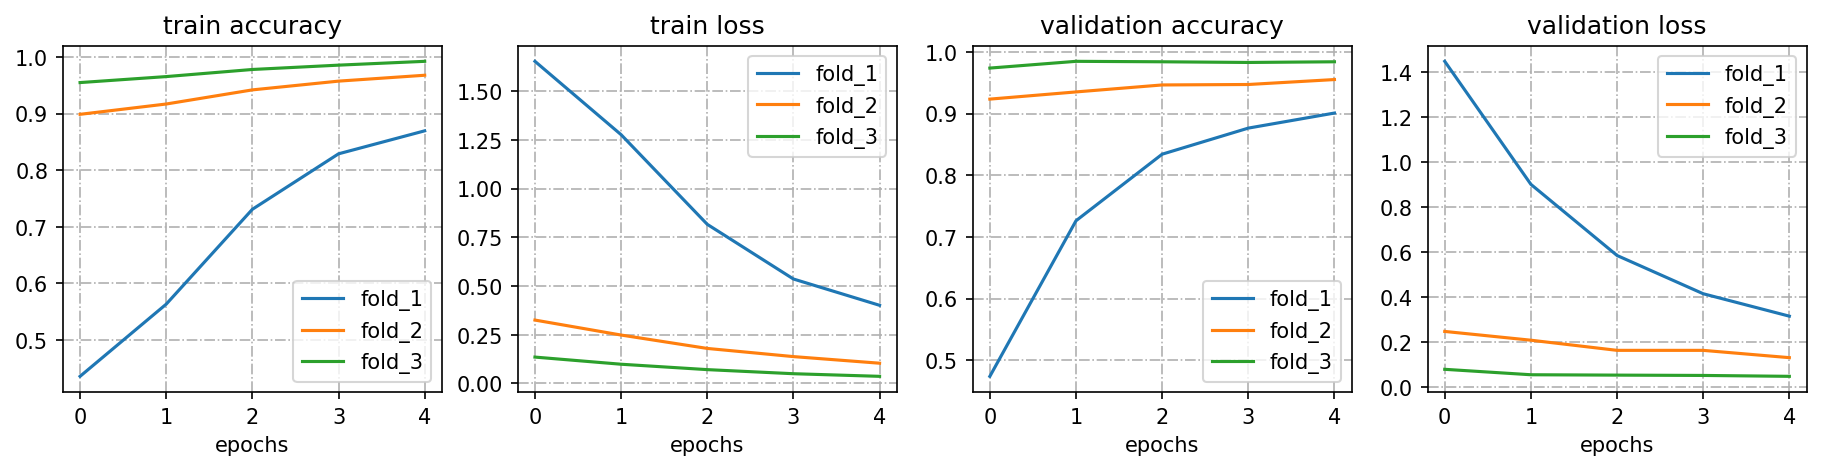

In [9]:
fig, axs = plt.subplots(1,4, figsize = (15,3) ,dpi = 150)

folds_name = []

axs[0].set_title('train accuracy')
axs[0].grid(linestyle = 'dashdot')
axs[0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0].plot(fold_hists[i].history['acc'])
    folds_name.append('fold_' + str(i + 1) )
axs[0].legend(folds_name, fontsize = 10)


axs[1].set_title('train loss')
axs[1].grid(linestyle = 'dashdot')
axs[1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1].plot(fold_hists[i].history['loss'])
axs[1].legend(folds_name, fontsize = 10)


axs[2].set_title('validation accuracy')
axs[2].grid(linestyle = 'dashdot')
axs[2].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[2].plot(fold_hists[i].history['val_acc'])
axs[2].legend(folds_name, fontsize = 10)


axs[3].set_title('validation loss')
axs[3].grid(linestyle = 'dashdot')
axs[3].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[3].plot(fold_hists[i].history['val_loss'])
axs[3].legend(folds_name, fontsize = 10)

# <span style="color:#e74c3c;"> Final </span> Test Predictions

In [10]:
# Calculating the mean of 3 folds predictions

preds = np.mean(test_preds, axis = 0)
last_pred = np.round(preds)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [11]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(last_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        pred = last_pred[idx[i]]

        axs[i].imshow(img) 
        axs[i].axis('off')
        axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + sport_classes[pred], fontsize = 8, color = 'red')

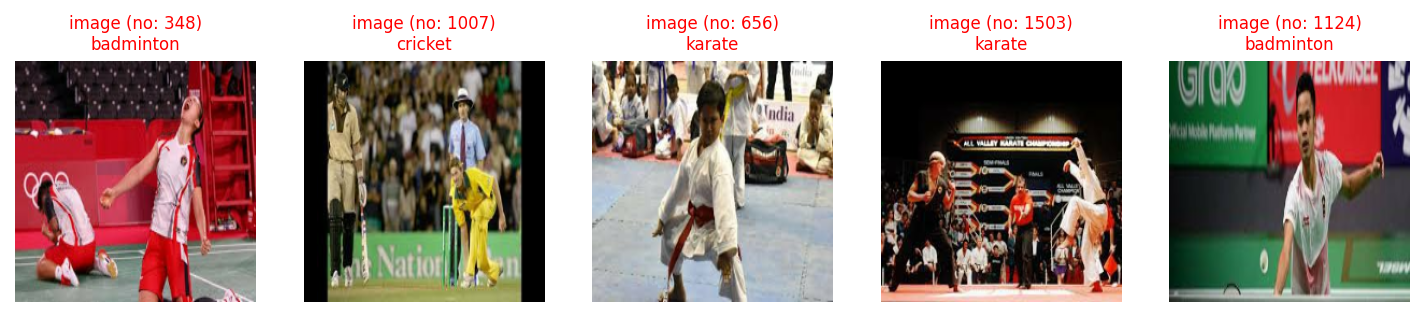

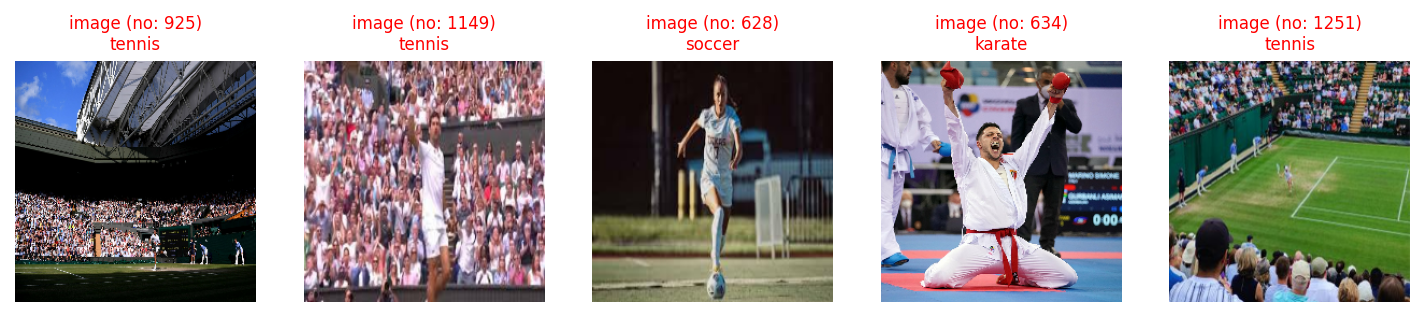

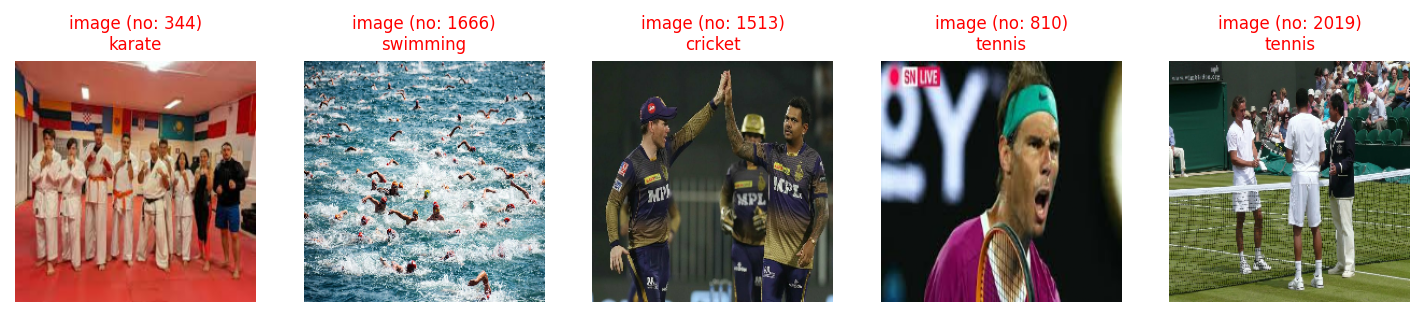

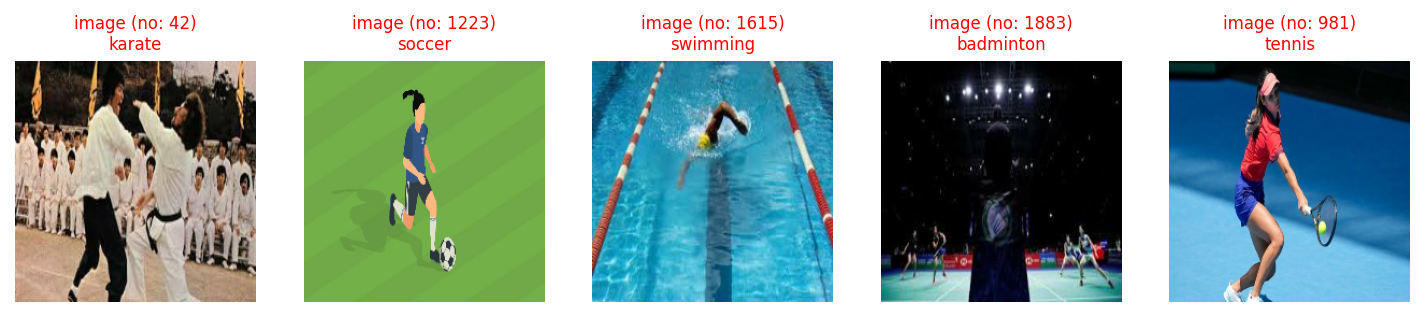

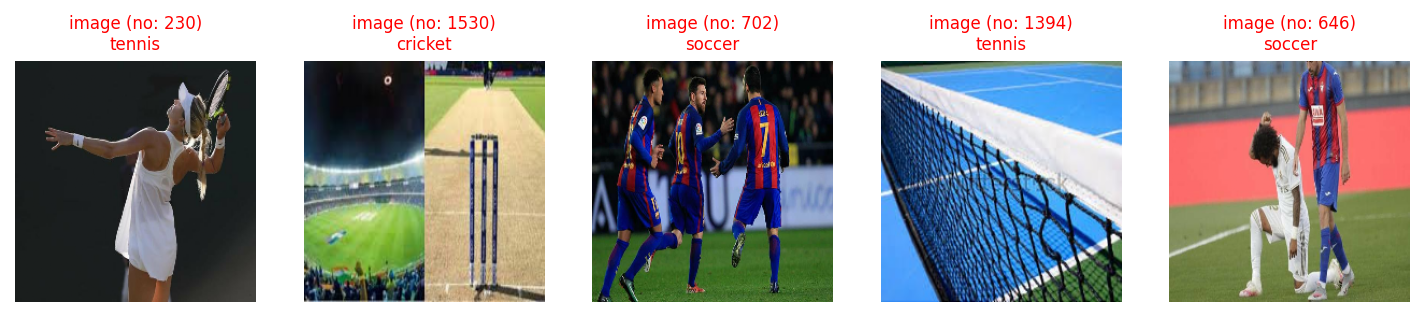

In [12]:
random_test_sample_with_prediction(SEED = 3)
random_test_sample_with_prediction(SEED = 95)
random_test_sample_with_prediction(SEED = 64)
random_test_sample_with_prediction(SEED = 92)
random_test_sample_with_prediction(SEED = 326)